In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/my-photos/mushroom.jpg
/kaggle/input/my-photos/cucu.jpg
/kaggle/input/image-localization-dataset/training_images/eggplant_35.jpg
/kaggle/input/image-localization-dataset/training_images/mushroom_17.jpg
/kaggle/input/image-localization-dataset/training_images/mushroom_28.xml
/kaggle/input/image-localization-dataset/training_images/eggplant_35.xml
/kaggle/input/image-localization-dataset/training_images/cucumber_57.jpg
/kaggle/input/image-localization-dataset/training_images/cucumber_30.jpg
/kaggle/input/image-localization-dataset/training_images/eggplant_10.xml
/kaggle/input/image-localization-dataset/training_images/eggplant_51.jpg
/kaggle/input/image-localization-dataset/training_images/mushroom_33.xml
/kaggle/input/image-localization-dataset/training_images/eggplant_54.xml
/kaggle/input/image-localization-dataset/training_images/eggplant_10.jpg
/kaggle/input/image-localization-dataset/training_images/mushroom_5.xml
/kaggle/input/image-localization-dataset/training_image

In [41]:
import os
import xml.etree.ElementTree as ET
from PIL import Image

# Path to the directory containing images and annotations
data_dir = "/kaggle/input/image-localization-dataset/training_images"

# List to store image paths and their corresponding bounding box info
data = []

# Iterate through image files in the directory
for filename in os.listdir(data_dir):
    if filename.endswith(".jpg"):
        image_path = os.path.join(data_dir, filename)
        
        xml_filename = os.path.splitext(filename)[0] + ".xml"
        xml_path = os.path.join(data_dir, xml_filename)
        
        if os.path.exists(xml_path):
            tree = ET.parse(xml_path)
            root = tree.getroot()

            object_info = root.find("object")
            class_label = object_info.find("name").text
            bbox = [
                int(object_info.find("bndbox/xmin").text),
                int(object_info.find("bndbox/ymin").text),
                int(object_info.find("bndbox/xmax").text),
                int(object_info.find("bndbox/ymax").text),
            ]
            
            data.append({"image_path": image_path, "class": class_label, "bbox": bbox})

# Print some information
print(f"Total images with annotations: {len(data)}")

# Now you can use the loaded data (image_path, class_label, bbox) for further processing.


Total images with annotations: 186


In [42]:
images=[]
name=[]
bbox=[]
for x in data:
    images.append(x['image_path'])
    name.append(x['class'])
    bbox.append(x['bbox'])

In [43]:
import cv2
import numpy as np

# Load images and store them in a list
image_list = []
for image_path in images:
    img = cv2.imread(image_path)  # Load image using OpenCV
    img = cv2.resize(img, (227, 227))  # Resize image to match model input size
    image_list.append(img)

# Convert the list of images to a NumPy array
image_array = np.array(image_list)

In [44]:
image_array.shape

(186, 227, 227, 3)

In [45]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd

encoder = OneHotEncoder()

encoder.fit(np.array(name).reshape(-1, 1))

encoded_data = encoder.transform(np.array(name).reshape(-1, 1))

encoded_array = encoded_data.toarray()

column_names = encoder.get_feature_names_out(input_features=['name'])
column_names=[x.split("_")[1] for x in column_names]
encodedNames = encoded_array.tolist()

outputs=[]
for i in range(len(name)):
    concatenated_value = bbox[i] + list(encodedNames[i])
    outputs.append(concatenated_value)
column_names=['x1','y1','x2','y2']+column_names
df_encoded = pd.DataFrame(outputs, columns=column_names)



In [46]:
np.array(outputs).shape

(186, 7)

In [47]:
from sklearn.model_selection import train_test_split

train_image_array, test_image_array, train_outputs, test_outputs = train_test_split(
    image_array, outputs, test_size=0.2, random_state=42
)

In [48]:
def custom_loss(y_true, y_pred):
    continuous_part_true = y_true[:, :4]
    binary_part_true = y_true[:, 4:]

    continuous_part_pred = y_pred[:, :4]
    binary_part_pred = y_pred[:, 4:]

    weight_mse = 1.0  # Weight for the regression part
    weight_ce = 5.0   # Weight for the classification part

    mse_continuous = tf.reduce_mean(tf.square(continuous_part_pred - continuous_part_true)) * weight_mse

    binary_loss = tf.keras.losses.binary_crossentropy(binary_part_true, binary_part_pred, from_logits=True)
    weighted_ce_loss = weight_ce * tf.reduce_mean(binary_loss)

    total_loss = mse_continuous + weighted_ce_loss
    return total_loss
def custom_activation(x):
    continuous_part = x[:, :4]
    binary_part = x[:, 4:]
    max_index = tf.argmax(binary_part, axis=-1)
    result = tf.one_hot(max_index, depth=tf.shape(binary_part)[-1])
    output = tf.concat([continuous_part, result], axis=-1)
    return output

In [49]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras import layers, models

# Define custom activation function

# Load the pretrained EfficientNetB0 model
# base_model = tf.keras.applications.EfficientNetB0(input_shape=(227, 227, 3),
#                                                   include_top=False,
#                                                   weights='imagenet')
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(227, 227, 3))

for layer in base_model.layers:
    layer.trainable=False
input_layer = layers.Input(shape=(227, 227, 3))
x = base_model(input_layer)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)

x = layers.Dropout(0.5)(x)

output_layer = layers.Dense(7)(x)  # 7-dimensional output
output_layer = layers.Lambda(custom_activation)(output_layer)

model = models.Model(inputs=input_layer, outputs=output_layer)






model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

model.summary()




Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, 8, 8, 2048)        58370944  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                           

In [50]:

# Early stopping and ModelCheckpoint callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',  # Path to save the best model
    save_best_only=True,       # Only save the best model
    save_weights_only=True,    # Save only weights
    monitor='val_loss',
    mode='min',                # 'min' if monitoring validation loss
    verbose=1
)

# Assuming you have validation data as well (val_image_array and val_outputs)
history = model.fit(
    train_image_array, np.array(train_outputs),
    epochs=100,
    validation_data=(test_image_array, np.array(test_outputs)),  # Use test data for validation
    callbacks=[early_stopping,model_checkpoint],  # Add the early stopping callback
    verbose=2
)

Epoch 1/100

Epoch 1: val_loss improved from inf to 14693.10352, saving model to best_model.h5
5/5 - 18s - loss: 17695.8359 - accuracy: 0.5068 - val_loss: 14693.1035 - val_accuracy: 0.5263 - 18s/epoch - 4s/step
Epoch 2/100

Epoch 2: val_loss improved from 14693.10352 to 6976.24658, saving model to best_model.h5
5/5 - 3s - loss: 11743.9404 - accuracy: 0.6689 - val_loss: 6976.2466 - val_accuracy: 0.5263 - 3s/epoch - 600ms/step
Epoch 3/100

Epoch 3: val_loss improved from 6976.24658 to 1408.17712, saving model to best_model.h5
5/5 - 4s - loss: 4754.9238 - accuracy: 0.6284 - val_loss: 1408.1771 - val_accuracy: 0.5263 - 4s/epoch - 749ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1408.17712
5/5 - 2s - loss: 3087.1511 - accuracy: 0.6216 - val_loss: 1954.0676 - val_accuracy: 0.5263 - 2s/epoch - 301ms/step
Epoch 5/100

Epoch 5: val_loss improved from 1408.17712 to 1144.47778, saving model to best_model.h5
5/5 - 3s - loss: 3149.8184 - accuracy: 0.5811 - val_loss: 1144.4778 - val_ac

In [51]:
from PIL import Image
import numpy as np

# Path to the uploaded image
image_path = '/kaggle/input/my-photos/cucu.jpg'  # Replace with the actual path

# Open and resize the image
try:
    image = Image.open(image_path)
    resized_image = image.resize((227, 227))
    
    # Convert the resized image to a numpy array
    photo = np.array(resized_image)
    
    print("Image resized successfully!")
except Exception as e:
    print("An error occurred:", str(e))



Image resized successfully!


1/1 [==============================] - 3s 3s/step


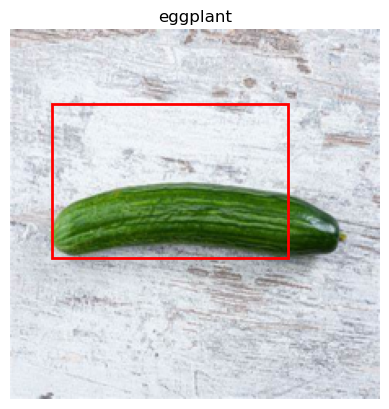

In [52]:
import matplotlib.patches as patches
i=135
single_image = photo  # Assuming image_array contains at least one image
single_image = np.expand_dims(single_image, axis=0)  # Add batch dimension
prediction = model.predict(single_image)
prediction=prediction.reshape(7)

cols=['cucumber','eggplant','mushroom']
softmax_array = prediction[4:]

index_of_1 = np.argmax(softmax_array)
predicted_class = cols[index_of_1]

xmin, ymin, xmax, ymax = prediction[:4]
    
plt.imshow(photo)
    
rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
    
plt.gca().add_patch(rect)
plt.title(predicted_class)    
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 35ms/step


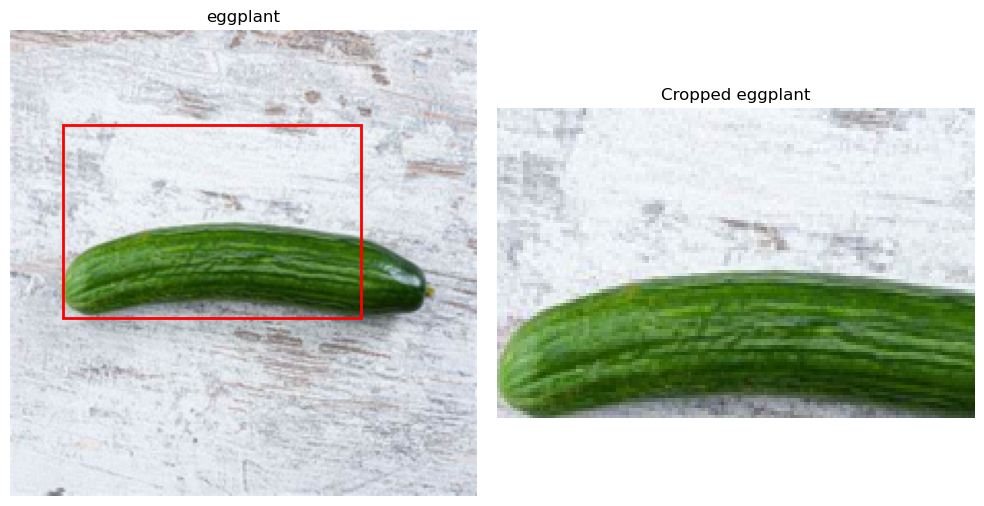

In [55]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Assuming you have defined `photo`, `model`, and other variables

i = 135
single_image = photo
single_image = np.expand_dims(single_image, axis=0)
prediction = model.predict(single_image)
prediction = prediction.reshape(7)

cols = ['cucumber', 'eggplant', 'mushroom']
softmax_array = prediction[4:]
index_of_1 = np.argmax(softmax_array)
predicted_class = cols[index_of_1]

xmin, ymin, xmax, ymax = prediction[:4]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image with the rectangle
axes[0].imshow(photo)
rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
axes[0].add_patch(rect)
axes[0].set_title(predicted_class)
axes[0].axis('off')

# Calculate the cropped region
cropped_image = photo[int(ymin):int(ymax), int(xmin):int(xmax)]

# Plot the cropped image
axes[1].imshow(cropped_image)
axes[1].set_title(f"Cropped {predicted_class}")
axes[1].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

plt.show()


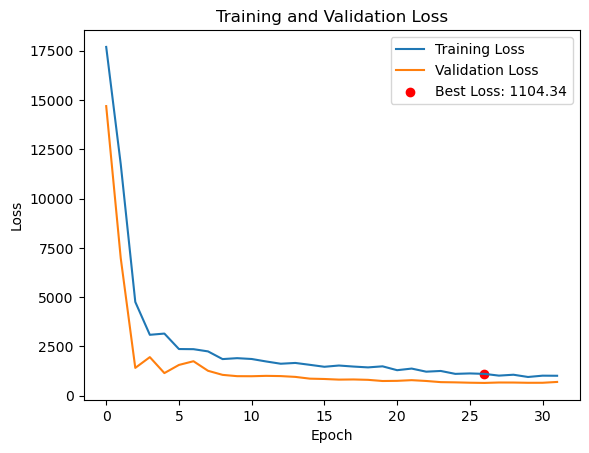

In [64]:
# Get the best epoch index
best_epoch_index = np.argmin(history.history['val_loss'])

# Extract loss values of the best epoch
best_loss = history.history['loss'][best_epoch_index]

# Plot training and validation loss with best model marked
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.scatter(best_epoch_index, best_loss, color='red', marker='o', label=f'Best Loss: {best_loss:.2f}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

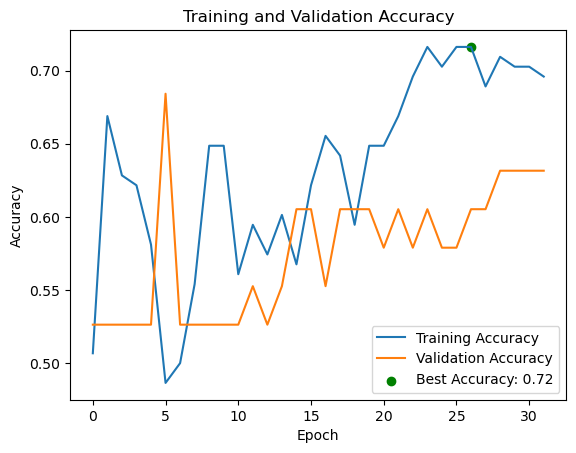

In [66]:
best_accuracy = history.history['accuracy'][best_epoch_index]

# Plot training and validation accuracy with best model marked
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.scatter(best_epoch_index, best_accuracy, color='green', marker='o', label=f'Best Accuracy: {best_accuracy:.2f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()